In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from linearmodels.panel import PanelOLS


## Data Cleaning
We downloaded both the financial fundamental and financial ratio data of North American companies from 2010-01-01 to 2020-12-31.

To perform data cleaning, we are going to merge the two data based on dates and company names. Then we will drop duplicated columns.

We also dropped missing rows and columns that has more than 30% of missing data. 

Last, we displayed the info of the cleaned data, and the summary statistics for the entire dataset, as well as the aggregated summary statistics for each company.

### Download and Merge data

In [2]:
ratios_df = pd.read_csv("data/company_ratios.csv")
fund_df = pd.read_csv("data/company_fundamentals.csv")

/tmp/ipykernel_118471/2249429491.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  fund_df = pd.read_csv("data/company_fundamentals.csv")


### Ratio
Ratio is monthly data, hence we group by the company and the year to extract yearly averages

In [3]:
ratios_df

,gvkey,adate,qdate,public_date,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,TICKER,cusip
0,1004,2009-05-31,2009-11-30,2010-01-31,0.082,0.201,0.095,0.651,0.498,0.466,3.586,186.451,2.272,1.001,AIR,00036110
1,1004,2009-05-31,2009-11-30,2010-02-28,0.082,0.201,0.095,0.651,0.498,0.466,3.586,186.451,2.272,1.001,AIR,00036110
2,1004,2009-05-31,2009-11-30,2010-03-31,0.082,0.201,0.095,0.651,0.498,0.466,3.586,186.451,2.272,1.001,AIR,00036110
3,1004,2009-05-31,2010-02-28,2010-04-30,0.081,0.195,0.086,0.676,0.473,0.545,3.893,183.882,2.312,0.987,AIR,00036110
4,1004,2009-05-31,2010-02-28,2010-05-31,0.081,0.195,0.086,0.676,0.473,0.545,3.893,183.882,2.312,0.987,AIR,00036110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480214,332115,2019-12-31,2020-06-30,2020-10-31,-645.190,NaN,-0.561,0.856,0.354,2.743,2.945,2895.150,NaN,0.001,ARMP,04216R10
480215,332115,2019-12-31,2020-09-30,2020-11-30,-59.082,NaN,-0.477,0.802,0.379,2.803,2.983,348.369,NaN,0.008,ARMP,04216R10
480216,332115,2019-12-31,2020-09-30,2020-12-31,-59.082,NaN,-0.477,0.802,0.379,2.803,2.983,348.369,NaN,0.008,ARMP,04216R10
480217,339965,2020-01-31,2020-07-31,2020-11-30,-0.868,0.625,-0.339,-0.780,0.528,1.180,1.631,130.301,NaN,0.329,NaN,NaN


In [4]:
aggregated_df = ratios_df
aggregated_df["public_date"] = pd.to_datetime(aggregated_df["public_date"])
# get year
aggregated_df["year"] = aggregated_df["public_date"].dt.year
pd.to_numeric(aggregated_df["gvkey"], errors="coerce")
# get numerical cols to average
numerical_cols = aggregated_df.select_dtypes(include=["number"]).columns
columns_to_keep = list(numerical_cols)
aggregated_df = aggregated_df[columns_to_keep]


# Group by gvkey and year and calculate yearly averages, ignoring NAs
aggregated_df = aggregated_df.groupby(["gvkey", "year"], as_index=False).mean()



In [5]:
aggregated_df

,gvkey,year,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,inv_turn,at_turn
0,1004,2010,0.07775,0.19850,0.088000,0.677750,0.487750,0.399500,3.337500,185.90325,2.27900,0.97475
1,1004,2011,0.07325,0.18350,0.094000,0.703000,0.503500,0.169250,2.468750,151.65975,2.74425,1.08675
2,1004,2012,0.07025,0.19500,0.111500,0.627250,0.561750,0.121000,2.294750,138.30300,2.90750,1.06175
3,1004,2013,0.06525,0.21025,0.114500,0.580500,0.583250,0.167500,2.542750,143.26375,2.82100,0.98875
4,1004,2014,0.06875,0.22375,0.110500,0.617750,0.554500,0.231250,2.823750,174.36450,2.39925,0.86350
...,...,...,...,...,...,...,...,...,...,...,...,...
42530,331856,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42531,331856,2020,NaN,NaN,NaN,0.993273,0.101545,5.125455,5.675091,NaN,NaN,NaN
42532,332115,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42533,332115,2020,-410.74680,NaN,-0.565125,0.878364,0.373545,2.246091,2.424182,1876.43760,NaN,0.00380


In [6]:
fund_df['year'] = pd.to_datetime(fund_df['datadate']).dt.year
pd.to_numeric(fund_df["gvkey"], errors="coerce")
fund_df

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,opincar,sale,uapt,xacc,xopr,xoprar,costat,county,naics,year
0,1004,2010-05-31,2009.0,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,1352.151,NaN,106.548,1217.806,NaN,A,NaN,423860.0,2010
1,1004,2011-05-31,2010.0,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,1775.782,NaN,116.839,1579.470,NaN,A,NaN,423860.0,2011
2,1004,2012-05-31,2011.0,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,2074.498,NaN,147.796,1851.805,NaN,A,NaN,423860.0,2012
3,1004,2013-05-31,2012.0,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,2167.100,NaN,152.100,1921.900,NaN,A,NaN,423860.0,2013
4,1004,2014-05-31,2013.0,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,2035.000,NaN,160.000,1779.000,NaN,A,NaN,423860.0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180936,356289,2023-06-30,2023.0,INDL,C,D,STD,SUUN,83417Y108,SOLARBANK CORP,...,NaN,18.398,NaN,NaN,21.025,NaN,A,NaN,2371.0,2023
180937,356289,2024-06-30,2024.0,INDL,C,D,STD,SUUN,83417Y108,SOLARBANK CORP,...,NaN,58.377,NaN,NaN,58.285,NaN,A,NaN,2371.0,2024
180938,356687,2021-12-31,2021.0,INDL,C,D,STD,SASKF,046824108,ATHA ENERGY CORP,...,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,212290.0,2021
180939,356687,2022-12-31,2022.0,INDL,C,D,STD,SASKF,046824108,ATHA ENERGY CORP,...,NaN,0.000,NaN,NaN,1.016,NaN,A,NaN,212290.0,2022


In [7]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42535 entries, 0 to 42534
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gvkey            42535 non-null  int64  
 1   year             42535 non-null  int32  
 2   opmad            40881 non-null  float64
 3   gpm              40703 non-null  float64
 4   roa              42231 non-null  float64
 5   equity_invcap    42122 non-null  float64
 6   debt_assets      42332 non-null  float64
 7   cash_ratio       34578 non-null  float64
 8   curr_ratio       34578 non-null  float64
 9   cash_conversion  31095 non-null  float64
 10  inv_turn         30858 non-null  float64
 11  at_turn          40868 non-null  float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 3.7 MB


In [8]:
fund_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180941 entries, 0 to 180940
Data columns (total 24 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   gvkey     180941 non-null  int64  
 1   datadate  180941 non-null  object 
 2   fyear     180601 non-null  float64
 3   indfmt    180941 non-null  object 
 4   consol    180941 non-null  object 
 5   popsrc    180941 non-null  object 
 6   datafmt   180941 non-null  object 
 7   tic       180819 non-null  object 
 8   cusip     180825 non-null  object 
 9   conm      180941 non-null  object 
 10  curcd     180601 non-null  object 
 11  capx      118127 non-null  float64
 12  oiadp     119021 non-null  float64
 13  oibdp     115609 non-null  float64
 14  opincar   1780 non-null    float64
 15  sale      119032 non-null  float64
 16  uapt      3441 non-null    float64
 17  xacc      75823 non-null   float64
 18  xopr      119019 non-null  float64
 19  xoprar    1812 non-null    float64
 20  cost

In [9]:
## Merge data
merged_df = pd.merge(
    aggregated_df,
    fund_df,
    left_on=['gvkey', 'year'],
    right_on=['gvkey', 'year'],
    how='inner'
)

In [10]:
merged_df

,gvkey,year,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,...,oibdp,opincar,sale,uapt,xacc,xopr,xoprar,costat,county,naics
0,1004,2010,0.07775,0.19850,0.088000,0.677750,0.487750,0.399500,3.337500,185.90325,...,134.345,NaN,1352.151,NaN,106.548,1217.806,NaN,A,NaN,423860.0
1,1004,2011,0.07325,0.18350,0.094000,0.703000,0.503500,0.169250,2.468750,151.65975,...,196.312,NaN,1775.782,NaN,116.839,1579.470,NaN,A,NaN,423860.0
2,1004,2012,0.07025,0.19500,0.111500,0.627250,0.561750,0.121000,2.294750,138.30300,...,222.693,NaN,2074.498,NaN,147.796,1851.805,NaN,A,NaN,423860.0
3,1004,2013,0.06525,0.21025,0.114500,0.580500,0.583250,0.167500,2.542750,143.26375,...,245.200,NaN,2167.100,NaN,152.100,1921.900,NaN,A,NaN,423860.0
4,1004,2014,0.06875,0.22375,0.110500,0.617750,0.554500,0.231250,2.823750,174.36450,...,256.000,NaN,2035.000,NaN,160.000,1779.000,NaN,A,NaN,423860.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46984,331856,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-26.282,NaN,0.000,NaN,3.298,26.282,NaN,A,NaN,325414.0
46985,331856,2020,NaN,NaN,NaN,0.993273,0.101545,5.125455,5.675091,NaN,...,-48.932,NaN,0.000,NaN,4.318,48.932,NaN,A,NaN,325414.0
46986,332115,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-16.638,NaN,0.000,NaN,2.054,16.638,NaN,A,NaN,325414.0
46987,332115,2020,-410.74680,NaN,-0.565125,0.878364,0.373545,2.246091,2.424182,1876.43760,...,-20.473,NaN,0.823,NaN,1.536,21.296,NaN,A,NaN,325414.0


In [11]:
merged_df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'cusip_x','cusip_y', 'TICKER', "cusip", 'gvkey', "curcd", "tic" , "public_date", "costat","popsrc","datafmt","indfmt", "consol", "adate", "qdate","fyear"], inplace=True, errors='ignore')


In [12]:
merged_df

,year,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,inv_turn,...,oiadp,oibdp,opincar,sale,uapt,xacc,xopr,xoprar,county,naics
0,2010,0.07775,0.19850,0.088000,0.677750,0.487750,0.399500,3.337500,185.90325,2.27900,...,95.415,134.345,NaN,1352.151,NaN,106.548,1217.806,NaN,NaN,423860.0
1,2011,0.07325,0.18350,0.094000,0.703000,0.503500,0.169250,2.468750,151.65975,2.74425,...,137.016,196.312,NaN,1775.782,NaN,116.839,1579.470,NaN,NaN,423860.0
2,2012,0.07025,0.19500,0.111500,0.627250,0.561750,0.121000,2.294750,138.30300,2.90750,...,142.360,222.693,NaN,2074.498,NaN,147.796,1851.805,NaN,NaN,423860.0
3,2013,0.06525,0.21025,0.114500,0.580500,0.583250,0.167500,2.542750,143.26375,2.82100,...,136.600,245.200,NaN,2167.100,NaN,152.100,1921.900,NaN,NaN,423860.0
4,2014,0.06875,0.22375,0.110500,0.617750,0.554500,0.231250,2.823750,174.36450,2.39925,...,142.600,256.000,NaN,2035.000,NaN,160.000,1779.000,NaN,NaN,423860.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46984,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-26.332,-26.282,NaN,0.000,NaN,3.298,26.282,NaN,NaN,325414.0
46985,2020,NaN,NaN,NaN,0.993273,0.101545,5.125455,5.675091,NaN,NaN,...,-48.971,-48.932,NaN,0.000,NaN,4.318,48.932,NaN,NaN,325414.0
46986,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-17.989,-16.638,NaN,0.000,NaN,2.054,16.638,NaN,NaN,325414.0
46987,2020,-410.74680,NaN,-0.565125,0.878364,0.373545,2.246091,2.424182,1876.43760,NaN,...,-21.587,-20.473,NaN,0.823,NaN,1.536,21.296,NaN,NaN,325414.0


### Drop missing columns and rows

In [13]:
## drop columns with more than 50% of NA
threshold = 0.5 * len(merged_df)
cleaned_df = merged_df.dropna(axis=1, thresh=threshold)


In [14]:
cleaned_df = cleaned_df.dropna()


In [15]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19127 entries, 0 to 46983
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             19127 non-null  int32  
 1   opmad            19127 non-null  float64
 2   gpm              19127 non-null  float64
 3   roa              19127 non-null  float64
 4   equity_invcap    19127 non-null  float64
 5   debt_assets      19127 non-null  float64
 6   cash_ratio       19127 non-null  float64
 7   curr_ratio       19127 non-null  float64
 8   cash_conversion  19127 non-null  float64
 9   inv_turn         19127 non-null  float64
 10  at_turn          19127 non-null  float64
 11  datadate         19127 non-null  object 
 12  conm             19127 non-null  object 
 13  capx             19127 non-null  float64
 14  oiadp            19127 non-null  float64
 15  oibdp            19127 non-null  float64
 16  sale             19127 non-null  float64
 17  xacc             

### Display data info and summary statistics

In [16]:
## set multiindex data based on company and dates
cleaned_df.set_index(['conm', 'year'], inplace=True)


In [17]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19127 entries, ('AAR CORP', np.int32(2010)) to ('ARCOSA INC', np.int32(2020))
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   opmad            19127 non-null  float64
 1   gpm              19127 non-null  float64
 2   roa              19127 non-null  float64
 3   equity_invcap    19127 non-null  float64
 4   debt_assets      19127 non-null  float64
 5   cash_ratio       19127 non-null  float64
 6   curr_ratio       19127 non-null  float64
 7   cash_conversion  19127 non-null  float64
 8   inv_turn         19127 non-null  float64
 9   at_turn          19127 non-null  float64
 10  datadate         19127 non-null  object 
 11  capx             19127 non-null  float64
 12  oiadp            19127 non-null  float64
 13  oibdp            19127 non-null  float64
 14  sale             19127 non-null  float64
 15  xacc             19127 non-null  float64
 16  xopr  

#### Drop date column

In [18]:
cleaned_df = cleaned_df[['opmad', 'gpm', 'roa', 'equity_invcap', 'debt_assets', 'cash_ratio',
       'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 
       'capx', 'oiadp', 'oibdp', 'sale', 'xacc', 'xopr', 'naics']]


In [19]:
# Describe based on total dataset
cleaned_df.describe()

,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,capx,oiadp,oibdp,sale,xacc,xopr,naics
count,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000
mean,-2.111995,-1.515620,0.057883,0.594124,0.527375,1.277559,2.878147,120.684297,62.157103,1.067522,269.432189,506.599291,727.393673,4577.220041,294.550977,3849.826368,349338.223611
std,57.552804,71.543861,0.258872,1.439826,0.331786,2.084972,2.477117,817.368815,1467.220712,0.797581,1208.102943,1962.042305,2680.348611,17888.988333,1146.485164,16029.940621,146704.909365
min,-5417.738583,-6243.000000,-4.496500,-92.506400,0.021500,0.000000,0.058917,0.000000,0.000000,0.000000,0.000000,-25913.000000,-21913.000000,-1.977000,0.000000,0.865000,42.000000
25%,-0.000408,0.226000,0.046167,0.492500,0.330875,0.213917,1.483750,39.752125,3.061500,0.571333,3.812500,0.024500,5.979000,143.787000,9.228000,139.761500,325412.000000
50%,0.066667,0.348750,0.107417,0.717000,0.513333,0.561667,2.181500,77.101111,5.193583,0.899333,24.871000,47.877000,82.300000,740.200000,42.106000,633.690000,334413.000000
75%,0.135000,0.498000,0.161667,0.956833,0.678458,1.443436,3.360792,128.494167,11.483187,1.381000,117.492000,277.953500,412.924500,2768.000000,167.198000,2285.647500,423860.000000
max,0.664083,0.998000,5.187667,46.091250,24.324833,42.698333,49.148167,58392.884500,120266.000000,20.670625,37985.000000,52959.000000,65259.000000,521426.000000,28965.000000,491287.000000,999990.000000


In [20]:
# Describe the data based on each company over the years
cleaned_df.groupby('conm').describe().transpose()


conm         1-800-FLOWERS.COM  10X GENOMICS INC  1LIFE HEALTHCARE INC  \
opmad count           9.000000          2.000000                1.0000   
      mean            0.038843         -0.164833               -0.2645   
      std             0.010251          0.070475                   NaN   
      min             0.023917         -0.214667               -0.2645   
      25%             0.034083         -0.189750               -0.2645   
...                        ...               ...                   ...   
naics min        455110.000000     325413.000000           621112.0000   
      25%        455110.000000     325413.000000           621112.0000   
      50%        455110.000000     325413.000000           621112.0000   
      75%        455110.000000     325413.000000           621112.0000   
      max        455110.000000     325413.000000           621112.0000   

conm         22ND CENTURY GROUP INC  3D SYSTEMS CORP          3M CO  \
opmad count                7.000000        11.000000      11.000000   
      mean                -2.420524         0.031674       0.223864   
      std                  4.453020         0.111586       0.008469   
      min                -12.470083        -0.098750       0.211167   
      25%                 -1.087708        -0.071667       0.217375   
...                             ...              ...            ...   
naics min             312230.000000    333248.000000  999977.000000   
      25%             312230.000000    333248.000000  999977.000000   
      50%             312230.000000    333248.000000  999977.000000   
      75%             312230.000000    333248.000000  999977.000000   
      max             312230.000000    333248.000000  999977.000000   

conm           3PAR INC  6D GLOBAL TECHNOLOGIES  99 CENTS ONLY STORES  \
opmad count       1.000                2.000000              2.000000   
      mean       -0.019                0.072333              0.076292   
      std           NaN                0.183376              0.010666   
      min        -0.019               -0.057333              0.068750   
      25%        -0.019                0.007500              0.072521   
...                 ...                     ...                   ...   
naics min    334112.000           541512.000000         452990.000000   
      25%    334112.000           541512.000000         452990.000000   
      50%    334112.000           541512.000000         452990.000000   
      75%    334112.000           541512.000000         452990.000000   
      max    334112.000           541512.000000         452990.000000   

conm         A-MARK PRECIOUS METALS INC  ...    ZOGENIX INC  \
opmad count                    7.000000  ...      10.000000   
      mean                     0.001494  ...     -17.092959   
      std                      0.001184  ...      32.831552   
      min                      0.000000  ...    -102.279500   
      25%                      0.000667  ...      -8.360833   
...                                 ...  ...            ...   
naics min                 423510.000000  ...  325412.000000   
      25%                 423510.000000  ...  325412.000000   
      50%                 423510.000000  ...  325412.000000   
      75%                 423510.000000  ...  325412.000000   
      max                 423510.000000  ...  325412.000000   

conm         ZOLL MEDICAL CORP  ZOOM TECHNOLOGIES INC     ZORAN CORP  \
opmad count           2.000000               2.000000       1.000000   
      mean            0.056167               0.058167      -0.037333   
      std             0.024749               0.010135            NaN   
      min             0.038667               0.051000      -0.037333   
      25%             0.047417               0.054583      -0.037333   
...                        ...                    ...            ...   
naics min        334510.000000          334220.000000  334413.000000   
      25%        334510.000000          334220.0

### Graph the Distribution of return on asset

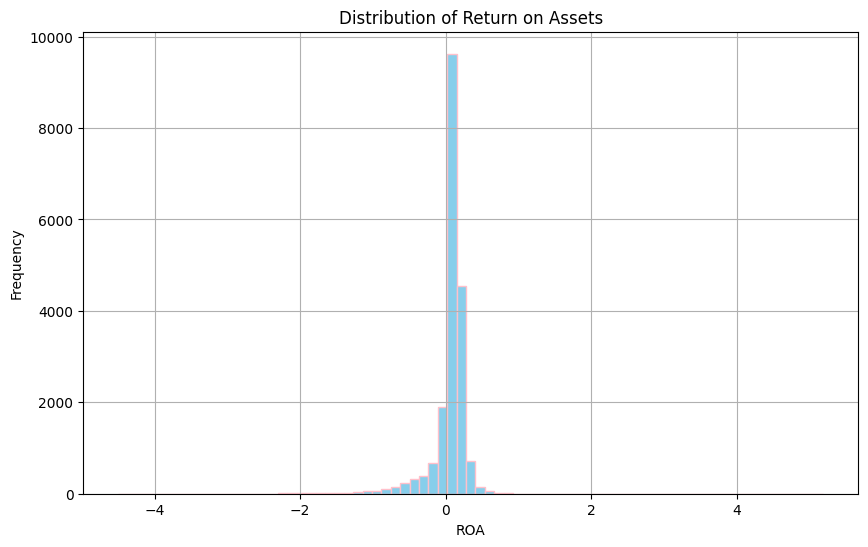

In [21]:
plt.figure(figsize=(10, 6))
cleaned_df['roa'].hist(bins=75, edgecolor='pink', color='skyblue')
plt.title('Distribution of Return on Assets')
plt.xlabel('ROA')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [22]:

X = cleaned_df.drop(columns=['roa'])  # Dropping the 'roa' column and 'datadate' (since it's not numeric)
y = cleaned_df['roa']

# Fit the OLS model

linear_model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True, check_rank=False).fit()

# Print the summary of the regression model
print(linear_model)



/tmp/ipykernel_118471/3074616693.py:6: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

xopr

  linear_model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True, check_rank=False).fit()


                          PanelOLS Estimation Summary                           
Dep. Variable:                    roa   R-squared:                        0.1397
Estimator:                   PanelOLS   R-squared (Between):              0.1077
No. Observations:               19127   R-squared (Within):               0.1426
Date:                Wed, Nov 20 2024   R-squared (Overall):              0.0812
Time:                        23:22:09   Log-likelihood                 1.758e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      186.45
Entities:                        3022   P-value                           0.0000
Avg Obs:                       6.3293   Distribution:                F(14,16081)
Min Obs:                       1.0000                                           
Max Obs:                       12.000   F-statistic (robust):             309.11
                            

## Correlation between predictor variables and outcome variable

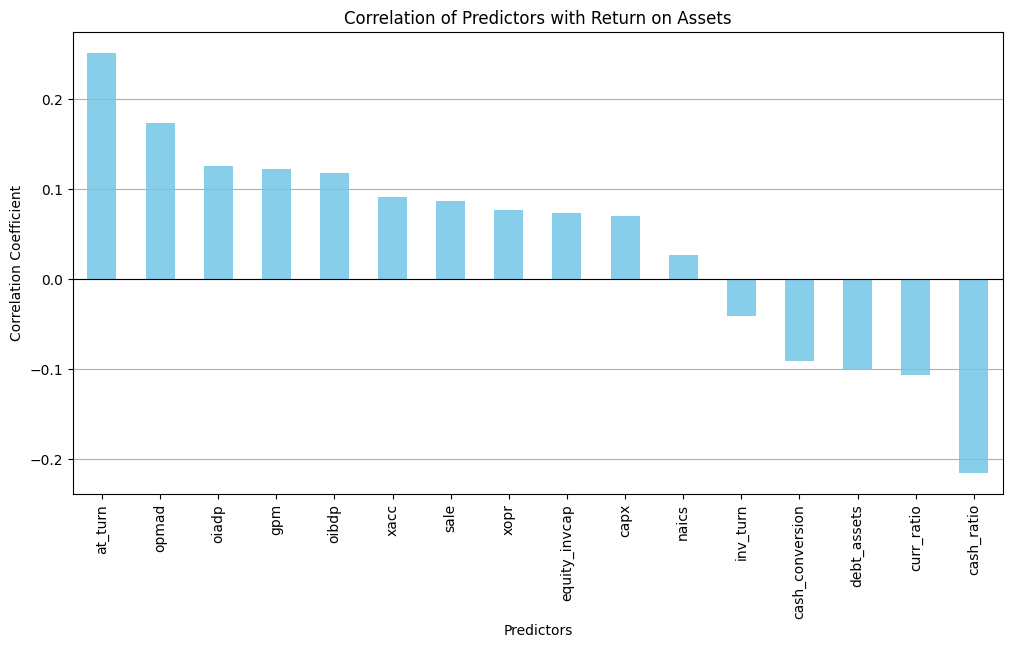

In [23]:
correlation_matrix = cleaned_df.corr()

# Step 2: Extract the correlations between 'roa' and the other predictors
roa_correlation = correlation_matrix['roa'].drop('roa').sort_values(ascending=False)

# Display the correlation values in a table
plt.figure(figsize=(12, 6))
roa_correlation.plot(kind='bar', color='skyblue')
plt.title('Correlation of Predictors with Return on Assets')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Predictors')
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y')
plt.show()


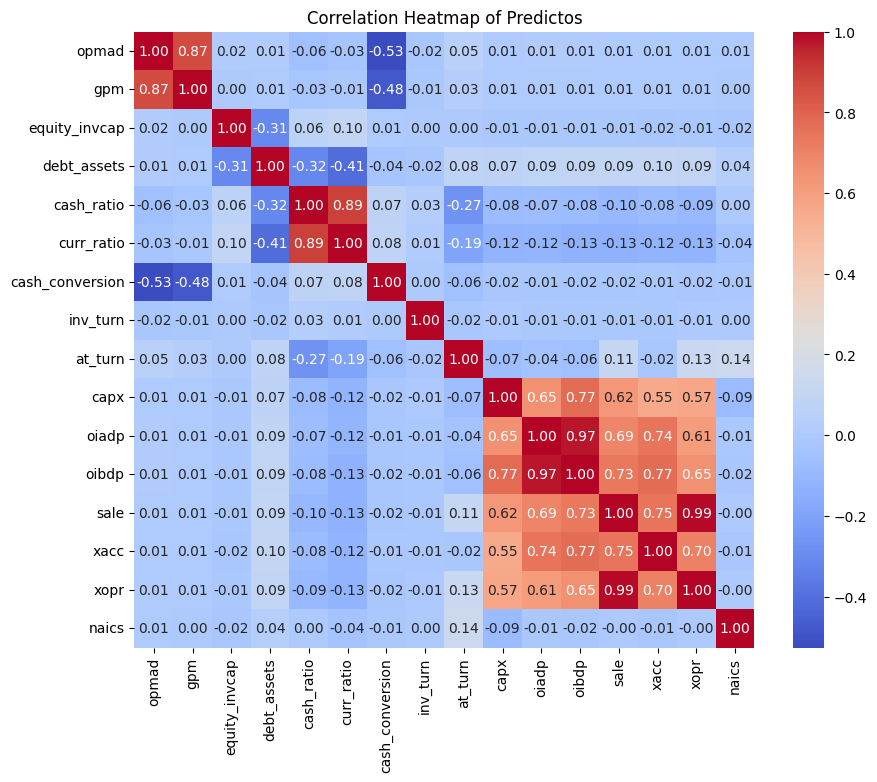

Variance Inflation Factor (VIF):
           Variable        VIF
0             const  17.863933
1             opmad   4.297772
2               gpm   4.042171
3     equity_invcap   1.108329
4       debt_assets   1.344119
5        cash_ratio   5.461334
6        curr_ratio   5.734004
7   cash_conversion   1.400829
8          inv_turn   1.003033
9           at_turn   1.193229
10             capx   4.634268
11            oiadp  30.504315
12            oibdp        inf
13             sale        inf
14             xacc   3.201863
15             xopr        inf
16            naics   1.049681


/home/mackenziequ/Projects/machinelearning/.venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [24]:
predictors = ['opmad', 'gpm', 'equity_invcap', 'debt_assets', 'cash_ratio',
       'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'capx', 'oiadp',
       'oibdp', 'sale', 'xacc', 'xopr', 'naics']
X = cleaned_df[predictors]

#Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Predictos")
plt.show()

#Calculate VIF
X_with_const = sm.add_constant(X) # adding constant to VIF calculation
vif_data = pd.DataFrame({
    'Variable': X_with_const.columns,
    'VIF': [variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])]
})

print('Variance Inflation Factor (VIF):')
print(vif_data)

We can see from these results that there is high correlation between certain variables. Specifically between Total Sales/Revenue & Operating Expenses('sale & xopr'), Operating Income Before Depreciation & Operating Income After Depreciation('oaibdp & oaidp'), and Gross Profit Margin and Operating Margin('gpm & opmad'). 

In the next cell, we will perform principal component analysis to address the issue of multicollinearity before dropping these variables. The PCA will reduce the number of features by only retaining the variables which explain the majority of the variance in the data

We are deleting Current ratio and OIBDP

In [25]:
# Performing Principle Component Analysis

predictors = ['xopr', 'oibdp', 'oiadp','opmad','gpm', 'equity_invcap', 'debt_assets', 'cash_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'capx',
       'curr_ratio', 'sale', 'xacc', 'naics']

X = cleaned_df[predictors]
Y = cleaned_df['roa']

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=None) # initially keep all components
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio for each principle component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio by Principal Component:")
for i, ev in enumerate(explained_variance, start=1):
    print(f"PC{i}: {ev:.2%}")

# Determine the number of components to explain 95% variance
cumulative_variance = explained_variance.cumsum()
n_components = (cumulative_variance < 0.95).sum() + 1
print(f"Using the first {n_components} principal components.")

# Reduce the dataset to the selectted number of components
X_pca_reduced = X_pca[:, :n_components]

# Perform regression using the reduced dataset
regressor = LinearRegression()
regressor.fit(X_pca_reduced, Y)

# Predict and evaluate the model
y_pred = regressor.predict(X_pca_reduced)
r2 = r2_score(Y, y_pred)
print(f"R-squared: {r2:.2f}")

# Coefficients of the principal components
coefficients = regressor.coef_
print(f"Regression Coefficients for the {n_components} Principal Components:")
for i, coef in enumerate(coefficients, start=1):
    print(f"PC{i}: {coef:.4f}")



Explained Variance Ratio by Principal Component:
PC1: 29.28%
PC2: 14.76%
PC3: 13.20%
PC4: 7.35%
PC5: 6.79%
PC6: 6.25%
PC7: 5.44%
PC8: 3.88%
PC9: 3.72%
PC10: 3.61%
PC11: 2.73%
PC12: 1.49%
PC13: 0.83%
PC14: 0.58%
PC15: 0.08%
PC16: 0.00%
Using the first 11 principal components.
R-squared: 0.15
Regression Coefficients for the 11 Principal Components:
PC1: 0.0146
PC2: 0.0316
PC3: 0.0014
PC4: 0.0544
PC5: -0.0136
PC6: -0.0076
PC7: -0.0125
PC8: -0.0556
PC9: 0.0218
PC10: 0.0272
PC11: -0.0232


## OLS regression data processing

We belive that the ROA of a given company can be predicted with the below estimators:
'opmad', 'gpm', 'roa', 'equity_invcap', 'debt_assets', 'cash_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'datadate', 'capx', 'oiadp', 'oibdp', 'opincar', 'sale', 'uapt', 'xacc','xopr', 'xoprar', 'county', 'naics'

$$
\text{ROA} = \beta_0 + \beta_1 \text{opmad} + \beta_2 \text{gpm} + \beta_3 \text{equity\_invcap} + \beta_4 \text{debt\_assets} 
$$
$$
+ \beta_5 \text{cash\_ratio} + \beta_6 \text{curr\_ratio} + \beta_7 \text{cash\_conversion} + \beta_8 \text{inv\_turn} $$ 
$$+ \beta_9 \text{at\_turn} + \beta_{11} \text{capx} + \beta_{12} \text{oiadp} + \beta_{13} \text{oibdp} + \beta_{14} \text{opincar} + \beta_{15}$$ 
$$ \text{sale} + \beta_{16} \text{uapt} + \beta_{17} \text{xacc} + \beta_{18} \text{xopr} + \beta_{19} \text{xoprar} + \beta_{20} \text{county} + \beta_{21} \text{naics} + \epsilon
$$


Where
opmad: Operating Margin, representing profitability from core operations. XXX


gpm: Gross Profit Margin, indicating the percentage of revenue that exceeds the cost of goods sold.


equity_invcap: Equity to Invested Capital Ratio, reflecting the proportion of equity in the capital structure.


debt_assets: Debt to Assets Ratio, indicating leverage levels. 


cash_ratio: Cash Ratio, measuring liquidity by comparing cash and equivalents to current liabilities.


curr_ratio: Current Ratio, assessing the ability to cover short-term obligations. XXX


cash_conversion: Cash Conversion Cycle, indicating how quickly a company converts investments into cash flows.


inv_turn: Inventory Turnover Ratio, showing how efficiently inventory is managed.


at_turn: Asset Turnover Ratio, indicating how effectively assets generate sales.


sale: Total sales or revenue.


capx: Capital Expenditure, representing funds used for acquiring or upgrading assets.


oiadp: Operating Income After Depreciation, reflecting core profitability.


oibdp: Operating Income Before Depreciation. XXX


xacc: Accruals, showing non-cash adjustments to earnings.


xopr: Operating Expenses. XXX

In [26]:
predictors

['xopr',
 'oibdp',
 'oiadp',
 'opmad',
 'gpm',
 'equity_invcap',
 'debt_assets',
 'cash_ratio',
 'cash_conversion',
 'inv_turn',
 'at_turn',
 'capx',
 'curr_ratio',
 'sale',
 'xacc',
 'naics']

### PCA Model

In [27]:

import statsmodels.api as sm

# Since your predictors are now the first 11 principal components in X_pca_reduced
# Add a constant (intercept) term to the predictors
X_pca_reduced_with_intercept = sm.add_constant(X_pca_reduced)

# Fit the model using statsmodels
pca_model = sm.OLS(Y, X_pca_reduced_with_intercept)  # Ordinary Least Squares regression
pca_model = pca_model.fit()

# Print the regression summary
print(pca_model.summary())


                            OLS Regression Results                            
Dep. Variable:                    roa   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     308.4
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:22:11   Log-Likelihood:                 271.64
No. Observations:               19127   AIC:                            -519.3
Df Residuals:                   19115   BIC:                            -425.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0579      0.002     33.546      0.0

### VIF Model

In [28]:
vif_data = pd.DataFrame()
vif_data['Variable'] = cleaned_df.columns
vif_data['VIF'] = [variance_inflation_factor(cleaned_df.values, i) for i in range(cleaned_df.shape[1])]

# Drop columns with high VIF (e.g., VIF > 10 indicates multicollinearity)
high_vif_columns = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()
high_vif_columns

/home/mackenziequ/Projects/machinelearning/.venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


['curr_ratio', 'oiadp', 'oibdp', 'sale', 'xopr']

In [29]:
X = cleaned_df.drop(columns = ['roa'])
X = X.drop(columns=high_vif_columns)
y = cleaned_df["roa"]


vif_model = PanelOLS(y, X, entity_effects = True, time_effects = True, drop_absorbed = True).fit()

print(vif_model)

/tmp/ipykernel_118471/4236277101.py:6: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

naics

  vif_model = PanelOLS(y, X, entity_effects = True, time_effects = True, drop_absorbed = True).fit()


                          PanelOLS Estimation Summary                           
Dep. Variable:                    roa   R-squared:                        0.1363
Estimator:                   PanelOLS   R-squared (Between):              0.0740
No. Observations:               19127   R-squared (Within):               0.1393
Date:                Wed, Nov 20 2024   R-squared (Overall):              0.1039
Time:                        23:22:12   Log-likelihood                 1.754e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      253.86
Entities:                        3022   P-value                           0.0000
Avg Obs:                       6.3293   Distribution:                F(10,16085)
Min Obs:                       1.0000                                           
Max Obs:                       12.000   F-statistic (robust):             253.86
                            

### Fixed Effects Model

In [30]:
# Fixed Effects Model

y = cleaned_df['roa']
x = cleaned_df.drop(columns='roa')

#X = sm.add_constant(X)

# Fit the Fixed Effects Model
fe_model = PanelOLS(y, x, entity_effects=True, time_effects=True, drop_absorbed=True, check_rank=False)
fe_model= fe_model.fit()

print(fe_model)

/tmp/ipykernel_118471/2604326707.py:10: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

xopr

  fe_model= fe_model.fit()


                          PanelOLS Estimation Summary                           
Dep. Variable:                    roa   R-squared:                        0.1397
Estimator:                   PanelOLS   R-squared (Between):              0.1077
No. Observations:               19127   R-squared (Within):               0.1426
Date:                Wed, Nov 20 2024   R-squared (Overall):              0.0812
Time:                        23:22:12   Log-likelihood                 1.758e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      186.45
Entities:                        3022   P-value                           0.0000
Avg Obs:                       6.3293   Distribution:                F(14,16081)
Min Obs:                       1.0000                                           
Max Obs:                       12.000   F-statistic (robust):             309.11
                            

In [32]:
print("Linear Model:")
print(linear_model)
print("\n\nPCA Model:")
print(pca_model.summary())
print("\n\nVIF Model:")
print(vif_model)
print("\n\nFixed Effects Model:")
print(fe_model)

Linear Model:
                          PanelOLS Estimation Summary                           
Dep. Variable:                    roa   R-squared:                        0.1397
Estimator:                   PanelOLS   R-squared (Between):              0.1077
No. Observations:               19127   R-squared (Within):               0.1426
Date:                Wed, Nov 20 2024   R-squared (Overall):              0.0812
Time:                        23:22:09   Log-likelihood                 1.758e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      186.45
Entities:                        3022   P-value                           0.0000
Avg Obs:                       6.3293   Distribution:                F(14,16081)
Min Obs:                       1.0000                                           
Max Obs:                       12.000   F-statistic (robust):             309.11
              

## 1. Linear Regression Model
### Highlights:
- R-squared: 0.1397 
- F-statistic: 186.45 with a p-value < 0.0001, indicating strong model significance.

### Key Coefficients:
- opmad (Operating Margin): 0.0004 (p < 0.0001)

- gpm (Gross Profit Margin): -5.843e-05 (p = 0.0296), negative and significant.

- equity_invcap (Equity to Invested Capital Ratio): 0.0030 (p < 0.0001), positive and significant.

- debt_assets (Debt to Assets Ratio): -0.1252 (p < 0.0001), significant and negative, indicating higher debt levels decrease ROA.

- cash_ratio (Cash Ratio): 0.0033 (p = 0.0811), significant at the 10% level.

- curr_ratio (Current Ratio): 0.0031 (p = 0.0455), significant at the 5% level.

### Qualitative Insights:

The model uses entity and time effects, which control for unobserved heterogeneity across companies and over time, improving the accuracy of estimates by accounting for firm-specific and time-specific factors.
The negative effect of gpm and debt_assets shows a consistent pattern of how profitability and leverage affect ROA. While the cash_ratio has a positive but weak effect, curr_ratio is more significant.

# 2. Principal Component Analysis Model

### Key Insights:
- R-squared: 0.151, a slight improvement over the Linear model, indicating better explanatory power.
- F-statistic: 308.4 

### Key Coefficients:
- Principal Component 1: 0.0146 (p < 0.0001)

- Principal Component 2: 0.0316 (p < 0.0001)

- Principal Component 3: 0.0014 (p = 0.231)

- Principal Component: 0.0544 (p < 0.0001)

- PC5 to PC11: Coefficients for these components are significant with varying signs.

### Qualitative Insights:

PCA is used to reduce multicollinearity by transforming the original variables into a smaller set of uncorrelated components. This allows for a more interpretable model that captures underlying patterns from correlated variables.
The coefficients for PC1, PC2, and PC4 are notably significant. These components capture the most variance in the dataset, likely aggregating several related financial ratios (e.g., profitability measures, liquidity measures). The PC3 coefficient, while still positive, is not significant, indicating that it does not add explanatory power in the context of ROA.
Unlike the PanelOLS model, the PCA approach treats these principal components as independent predictors, rather than retaining the original features.

# 3. Variance Inflation Factor Model

### Key Insights:
- R-squared: 0.1363 
- F-statistic: 253.86 (p < 0.0001)

### Key Coefficients:
- opmad: 0.0004 (p < 0.0001)

- gpm: -5.911e-05 (p = 0.0280)

- equity_invcap: 0.0030 (p = 0.0001)

- debt_assets: -0.1260 (p < 0.0001)

- cash_ratio: 0.0067 (p < 0.0001), stronger positive effect compared to the PanelOLS and PCA models.

- xacc (Accruals): 5e-06 (p = 0.0687), marginally significant.

### Qualitative Insights:

The VIF Model focuses on reducing multicollinearity by assessing the extent to which multicollinearity is an issue in the regression. The model adjusts for high correlation between predictors, which is especially relevant in datasets with many financial ratios.
Compared to PanelOLS, cash_ratio shows a stronger positive relationship with ROA in the VIF model. This suggests that after adjusting for multicollinearity, the cash ratio’s true effect on ROA is more prominent.
The debt_assets coefficient is slightly more negative in the VIF model, indicating a more pronounced negative effect of debt on ROA after adjusting for multicollinearity.

# 4. Fixed Effects Model

### Key Insights:
- R-squared: 0.1397, identical to the first PanelOLS model.
- F-statistic: 186.45 

### Key Coefficients:
- opmad: 0.0004 (p < 0.0001)
- gpm: -5.843e-05 (p = 0.0296)
- equity_invcap: 0.0030 (p < 0.0001)
- debt_assets: -0.1252 (p < 0.0001)
- cash_ratio: 0.0033 (p = 0.0811)
- curr_ratio: 0.0031 (p = 0.0455)

### Qualitative Insights:

The Fixed Effects Model is similar to the initial PanelOLS, with entity and time effects included to account for unobserved heterogeneity. The results are consistent with the first model in terms of coefficients and statistical significance.

The key distinction lies in the interpretation of the coefficients—these are adjusted for both individual entities (companies) and time. Therefore, the results account for all time-invariant characteristics of the entities (such as industry type, geographical location) and potential changes over time that may affect ROA.


## Key Changes and Explanations:

#### Principal Components Model:
The coefficients of PCA differ from the PanelOLS models, as it uses transformed principal components rather than individual features. PC1 and PC2 are highly significant, capturing underlying patterns of the original variables, whereas PC3 and later components show reduced significance.


#### VIF Model
The VIF Model adjusts for multicollinearity and changes the magnitude and significance of certain coefficients. The positive effect of cash_ratio becomes stronger compared to the PanelOLS and PCA models, which suggests that after adjusting for multicollinearity, the cash_ratio has a clearer positive relationship with ROA.

#### Fixed Effects Model:

The Fixed Effects Model does not produce substantial changes in coefficient values compared to the regular PanelOLS model but improves model robustness by controlling for unobserved heterogeneity. The results emphasize that firm-specific and time-specific effects are controlled for, which may explain why the coefficients are consistent